In [10]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [12]:
import pickle
import gzip
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [13]:
training_data, validation_data, test_data = load_data_wrapper()
print(f"{type(training_data)=}, {type(test_data)=}")
training_data = list(training_data)
test_data = list(test_data) 

type(training_data)=<class 'zip'>, type(test_data)=<class 'zip'>


# Preprocess the data

trainY[ind].T =array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


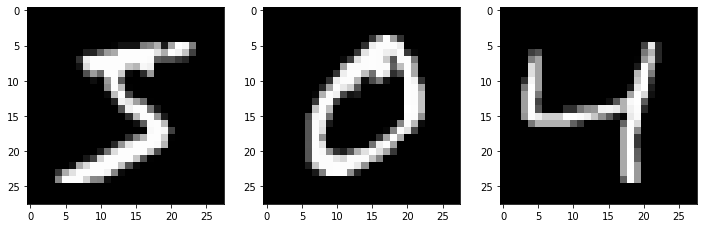

In [14]:
trainX, trainY, testX, testY = [], [], [], []

for sample in training_data:
    X = sample[0]
    Y = sample[1]
    trainX.append(X)
    trainY.append(Y)

for sample in test_data:
    X = sample[0]
    Y = sample[1]
    testX.append(X)
    testY.append(Y)

trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for ind in range(3):
    ax[ind].imshow(np.reshape(trainX[ind], (28, 28)), cmap='gray')
print(f"{trainY[ind].T =}")


In [15]:
print(f"{trainX.shape = }, {trainY.shape = }, {testX.shape = }, {testY.shape = }")
trainY = np.reshape(trainY, (50_000, 10))
print([trainY[:10]])
trainY = np.argmax(trainY, axis=1)
print(trainY[:10])
# trainY = np.reshape(trainY, (50_000,1))
# testY = np.reshape(testY, (10_000, 1))

print(f"{trainX.shape = }, {trainY.shape = }, {testX.shape = }, {testY.shape = }")


trainX.shape = (50000, 784, 1), trainY.shape = (50000, 10, 1), testX.shape = (10000, 784, 1), testY.shape = (10000,)
[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])]
[5 0 4 1 9 2 1 3 1 4]
trainX.shape = (50000, 784, 1), trainY.shape = (50000,), testX.shape = (10000, 784, 1), testY.shape = (10000,)


# Functions for model definition, training and evaluation

In [16]:

def get_model(hidden_units , l_r=0.001, kernel_init=None ):
    num_inputs = 784
    layers_list = []
    lyr_num = 0
    for width in hidden_units:
        if lyr_num == 0:
            layers_list.append(  tf.keras.layers.Dense(width, activation='sigmoid',input_shape=(num_inputs, ))  )
        elif kernel_init is not None:
            layers_list.append(  tf.keras.layers.Dense(width, activation='sigmoid', kernel_initializer=kernel_init)  )
        else:
            layers_list.append(  tf.keras.layers.Dense(width, activation='sigmoid')  )
        lyr_num += 1
    layers_list.append(tf.keras.layers.Dense(10, activation='softmax'))

    model = tf.keras.Sequential(layers_list)

    # model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_r),
                loss=tf.keras.losses.SparseCategoricalCrossentropy()
                )

    return model



def train_model(model):

    BATCH_SIZE = 100
    history = model.fit(
        x=trainX,
        y=trainY,
        batch_size=BATCH_SIZE,
        epochs=20,
        verbose=0
        )
    return model, history
    
def evaluate_model(model, history, condition, condition_type):
    results = dict()

    losses = history.history["loss"]

    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # ax.set_title(f"{condition_type} = {condition}")
    # ax.plot(losses,'o-', color='r', label="Training loss")
    # ax.legend()
    # ax.set_ylabel("Loss")
    # ax.set_xlabel("epoch")
    # plt.show()

    testLoss = model.evaluate(testX, testY, verbose=0)
    trainLoss = model.evaluate(trainX, trainY, verbose=0)
    
    p = model.predict(testX, verbose=0)
    pred = np.argmax(p, axis=1)
    pTrain = model.predict(trainX, verbose=0)
    predTrain = np.argmax(pTrain, axis=1)
    
    results['Test Loss'] = testLoss
    results['Test Accuracy'] = accuracy_score(testY, pred)
    results['Test Precision'] = precision_score(testY, pred, average = 'macro')
    results['Test Recall'] = recall_score(testY, pred, average = 'macro')
    results['Test F1 score'] = f1_score(testY, pred, average = 'macro')
    results['Test AUC'] = roc_auc_score(testY, p, average = 'macro', multi_class='ovr')

    results['Train Loss'] = trainLoss
    results['Train Accuracy'] = accuracy_score(trainY, predTrain)
    results['Train Precision'] = precision_score(trainY, predTrain, average = 'macro')
    results['Train Recall'] = recall_score(trainY, predTrain, average = 'macro')
    results['Train F1 score'] = f1_score(trainY, predTrain, average = 'macro')
    results['Train AUC'] = roc_auc_score(trainY, pTrain, average = 'macro', multi_class='ovr')

    return results




# run_tests function builds the model, runs it and tests it for different values of a hyperparameter.

# print_results function finds out the best hyperparameter from the results returned by run_tests function. It also prints the results and shows relevant plots.

In [17]:
# hidden units
# weight/bias initializations
# learning rates

from time import time

def print_results(results_list, condition_type):
    best_condition = None
    best_condition_acc = -1
    for r in results_list:
        condn, res = r
        print("-"*50)
        print(condition_type," => ",condn)
        print("-"*50)
        for k in res:
            spaces = " "*(20 - len(str(k)))
            print(f"{k} {spaces} = {res[k]:.4f}")
        if res["Test Accuracy"] > best_condition_acc:
            best_condition_acc = res["Test Accuracy"]
            best_condition = condn
        print()


    plt.title(f"{condition_type}")
    plt.plot([r[1]["Test Accuracy"] for r in results_list], 'o-', label="Test Accuracy")
    plt.plot([r[1]["Train Accuracy"] for r in results_list],'o-',  label="Train Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(f"{condition_type}")
    labels = []
    for r in results_list:
        if len(str(r[0])) > 15:
            removed_before_dot = str(r[0]).split(".")[-1]
            removed_after_space = removed_before_dot.split(" ")[0]
            labels.append(  removed_after_space  )
        else:
            labels.append(str(r[0]))
    plt.xticks([i for i in range(len(results_list))], labels)
    plt.legend()
    plt.show()
    
    print(f"Best {condition_type} = {best_condition}, with Test Accuracy = {best_condition_acc}")
    return best_condition, best_condition_acc

def run_tests(conditions, condition_type, fixed1=None, fixed2=None):
    start1 = time()
    res = []
    print(f"Trying different values for {condition_type}")
    for cn in conditions:
        start = time()
        print(f"\tTrying {condition_type} = {cn}")
        model = None
        if condition_type == "Hidden nodes":
            model = get_model(cn)
        if condition_type == "Learning Rate":
            model = get_model(fixed1, cn)
        if condition_type == "Weight Initialization":
            model = get_model(fixed1, fixed2, cn)
        
        model, history = train_model(model)
        results = evaluate_model(model, history, cn, condition_type)
        # print(f"Results = {results}")
        res.append([cn, results])
        now = time()
        # print(f"Time taken = {now - start} (sec). Total = {now-start1} (sec)")
    return res
    


Trying different values for Hidden nodes
	Trying Hidden nodes = [100, 10]
	Trying Hidden nodes = [1000, 100]
	Trying Hidden nodes = [20000, 1000]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------
Hidden nodes  =>  [100, 10]
--------------------------------------------------
Test Loss             = 0.0945
Test Accuracy         = 0.9732
Test Precision        = 0.9732
Test Recall           = 0.9729
Test F1 score         = 0.9730
Test AUC              = 0.9992
Train Loss            = 0.0302
Train Accuracy        = 0.9948
Train Precision       = 0.9948
Train Recall          = 0.9947
Train F1 score        = 0.9947
Train AUC             = 0.9999

--------------------------------------------------
Hidden nodes  =>  [1000, 100]
--------------------------------------------------
Test Loss             = 0.0901
Test Accuracy         = 0.9776
Test Precision        = 0.9774
Test Recall           = 0.9774
Test F1 score         = 0.9773
Test AUC              = 0.9997
Train Loss            = 0.0095
Train Accuracy        = 0.9969
Train Precision       = 0.9970
Train Recall          = 0.9969
Train F1 score        = 0.9969
Train AUC             = 

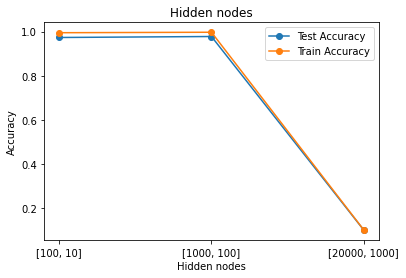

Best Hidden nodes = [1000, 100], with Test Accuracy = 0.9776


In [18]:
# hidden units

wts = [[100, 10], [1000, 100], [20_000, 1000]]

res = run_tests(wts, "Hidden nodes")
best_wt, _ = print_results(res, "Hidden nodes")

Trying different values for Learning Rate
	Trying Learning Rate = 0.01
	Trying Learning Rate = 0.001
	Trying Learning Rate = 0.0001
--------------------------------------------------
Learning Rate  =>  0.01
--------------------------------------------------
Test Loss             = 0.1140
Test Accuracy         = 0.9724
Test Precision        = 0.9724
Test Recall           = 0.9721
Test F1 score         = 0.9722
Test AUC              = 0.9991
Train Loss            = 0.0396
Train Accuracy        = 0.9885
Train Precision       = 0.9884
Train Recall          = 0.9885
Train F1 score        = 0.9884
Train AUC             = 0.9999

--------------------------------------------------
Learning Rate  =>  0.001
--------------------------------------------------
Test Loss             = 0.0723
Test Accuracy         = 0.9817
Test Precision        = 0.9816
Test Recall           = 0.9816
Test F1 score         = 0.9816
Test AUC              = 0.9998
Train Loss            = 0.0025
Train Accuracy        = 0

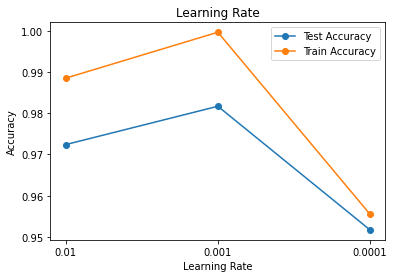

Best Learning Rate = 0.001, with Test Accuracy = 0.9817


In [19]:
lr = [0.01, 0.001, 0.0001]

res = run_tests(lr, "Learning Rate", best_wt, None)
best_lr, _ = print_results(res, "Learning Rate")

Trying different values for Weight Initialization
	Trying Weight Initialization = <keras.initializers.initializers_v2.HeNormal object at 0x7f682a372a60>
	Trying Weight Initialization = <keras.initializers.initializers_v2.RandomNormal object at 0x7f682a372e50>
	Trying Weight Initialization = <keras.initializers.initializers_v2.Constant object at 0x7f682a3725b0>


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------
Weight Initialization  =>  <keras.initializers.initializers_v2.HeNormal object at 0x7f682a372a60>
--------------------------------------------------
Test Loss             = 0.0753
Test Accuracy         = 0.9799
Test Precision        = 0.9800
Test Recall           = 0.9797
Test F1 score         = 0.9798
Test AUC              = 0.9997
Train Loss            = 0.0052
Train Accuracy        = 0.9985
Train Precision       = 0.9985
Train Recall          = 0.9985
Train F1 score        = 0.9985
Train AUC             = 1.0000

--------------------------------------------------
Weight Initialization  =>  <keras.initializers.initializers_v2.RandomNormal object at 0x7f682a372e50>
--------------------------------------------------
Test Loss             = 0.0705
Test Accuracy         = 0.9803
Test Precision        = 0.9802
Test Recall           = 0.9802
Test F1 score         = 0.9802
Test AUC              = 0.9998
Train Loss            = 0.0022
Train 

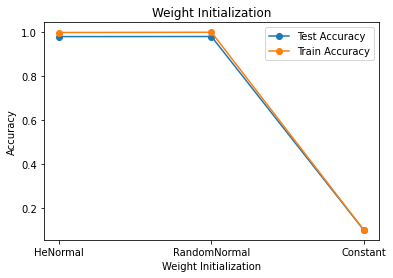

Best Weight Initialization = <keras.initializers.initializers_v2.RandomNormal object at 0x7f682a372e50>, with Test Accuracy = 0.9803


In [20]:
# # weight/bias initializations


ks = [tf.keras.initializers.HeNormal(), tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42), tf.keras.initializers.Constant(0.1)]

res = run_tests(ks, "Weight Initialization", best_wt, best_lr)
best_k, _ = print_results(res, "Weight Initialization")


In [21]:
print(f"Best hyperparameters: Hidden units = {best_wt}, learning rate = {best_lr}, Weight initialization = {best_k}")

Best hyperparameters: Hidden units = [1000, 100], learning rate = 0.001, Weight initialization = <keras.initializers.initializers_v2.RandomNormal object at 0x7f682a372e50>
